# Theano Basic concepts

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import warnings
import scipy.io
import numpy as np
import pandas as pd
import theano as th
import theano.tensor as T
from time import time
import sklearn as sk
import sklearn.metrics
from IPython.display import Image
from bokeh.models import ColumnDataSource
from addutils import css_notebook
import sys
import os
# import matplotlib.pyplot as plt # Just in case MAtplotlib is used
# %matplotlib inline
css_notebook()

In [3]:
import bokeh.plotting as bk
bk.output_notebook()

BokehJS successfully loaded.

## 1 Basic Linear Algebra

### 1.1 Adding two Scalars

By calling T.dscalar with a string argument, you create a Variable representing a floating-point scalar quantity with the given name. If you provide no argument, the symbol will be unnamed. Names are not required, but they can help debugging.

The first argument to function is a list of Variables that will be provided as inputs to the function. The second argument is a single Variable or a list of Variables. For either case, the second argument is what we want to see as output when we apply the function. f may then be used like a normal Python function.

In [4]:
x = T.dscalar('x') # This defines a symbol 'd' is for 'double'
y = T.dscalar('y') # This defines a symbol
z = x + y
f = th.function([x, y], z)

In [5]:
x.type

TensorType(float64, scalar)

In [6]:
print(th.pp(z)) # 'pp' is 'pretty print'

(x + y)


In [7]:
f(2, 3.5)

array(5.5)

### 1.2 Operations with two Matrices - element by element

In [8]:
A = np.array([[1, 2], [3, 4]])
B = np.array([[10, 20], [30, 40]])
x, y = T.dmatrices('x', 'y') # dmatrices is used to define more 'dmatrix' in a single instruction
                             # Alternatively use: #x, y = T.dmatrix('x'), T.dmatrix('y')
z = x + y
k = x**2+y**3
f1 = th.function([x, th.Param(y, default=B)], z) # Class 'Param' used to define a default value
f2 = th.function([x, y], [z, k]) # Functions can return more than a value

In [9]:
print(f1(A, B))

[[ 11.  22.]
 [ 33.  44.]]


In [10]:
print(f1(A))

[[ 11.  22.]
 [ 33.  44.]]


In [11]:
Z, K = f2(A, B)
print(Z)
print(K)

[[ 11.  22.]
 [ 33.  44.]]
[[  1001.   8004.]
 [ 27009.  64016.]]


## 2 Tensor Constructors

Theano defines tensor variables for symbolic computation. A tensor variable is characterized by dimension and type of its objects. Theano provides several constructors for creating a tensor variable, for example:

In [12]:
a = T.dmatrix('a')
print(a.type)

TensorType(float64, matrix)


Theano provides special constructors for a wide variety of variables and optional dtype, for example:

    scalar (return a Variable for a 0-dimensional ndarray)
    vector (return a Variable for a 1-dimensional ndarray)
    row (return a Variable for a 2-dimensional ndarray in which the number of rows is guaranteed to be 1.)
    col (return a Variable for a 2-dimensional ndarray in which the number of columns is guaranteed to be 1.)
    matrix (return a Variable for a 2-dimensional ndarray)
    tensor3 (return a Variable for a 3-dimensional ndarray)
    tensor4 (return a Variable for a 4-dimensional ndarray)
    
In all this cases it is possible to specify the type of the elements as a string in the constructor (dtype='typename'). Valid dtypes are int8, int16, int32, int64, float64, float32, complex64, complex128.

Moreover Theano provides special constructors with harcoded dtype, for example: dmatrix, dscalar and so on.

Tensor variables are then instantiated when used in a function. It is also possible to use a special method that constructs a function and assign a given value on the fly

In [13]:
a.eval({a: np.arange(9).reshape(3,3)})

array([[ 0.,  1.,  2.],
       [ 3.,  4.,  5.],
       [ 6.,  7.,  8.]])

Tensor variable are used for symbolic computation. It is also possible to assign values to a tensor variable, with special methods. For example we can create a matrix of zero elements with the same shape as a numpy ndarray.

In [14]:
x = th.shared(np.random.randn(3,4))
zeros = T.zeros_like(x)
zeros.eval()

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

Or a matrix with all ones.

In [15]:
ones = T.ones_like(x)
ones.eval()

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.]])

Finally it is possible to combine them.

In [16]:
stacked = T.stack([zeros, ones])
stacked.eval()

array([[[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]]])

Those methods assign an additional tensor constant associated with the tensor variable. The variable can still be used as symbol but it has an additional value, it looks like a default value. It can be used in function for example. Let's define a function that adds the two matrix `zeros` and `ones`:

In [17]:
add_zeros_ones = zeros + ones
f = th.function([], add_zeros_ones)
print(f())

[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]]


The two variables can still be used as symbols, for example in a new function.

In [18]:
f = th.function([zeros, ones], add_zeros_ones)
f(np.arange(9).reshape((3,3)), np.arange(9).reshape((3,3)))

array([[  0.,   2.,   4.],
       [  6.,   8.,  10.],
       [ 12.,  14.,  16.]])

## 3 Shared Variables

In a previous computation we introduced shared variables. A shared variable is a variable whose value may be shared between multiple functions.

For example it 'updates' parameter of a function: must be supplied with a list of pairs of the form (shared-variable, new expression). It can also be a dictionary whose keys are shared-variables and values are the new expressions.

It means “whenever this function runs, it will replace the .value of each shared variable with the result of the corresponding expression”.

In [19]:
int_state = th.shared(0) # Shared variable have an internal state shared in all the functions that use it
inc = T.iscalar('inc')
accumulator = th.function([inc], int_state, updates=[(int_state, int_state+inc)])
decrementor = th.function([inc], int_state, updates=[(int_state, int_state-inc)])

In [20]:
int_state.get_value()

array(0)

In [21]:
accumulator(5)
int_state.get_value()

array(5)

In [22]:
decrementor(2)
int_state.get_value()

array(3)

## 4 Indexing

Theano supports indexing like numpy array (although there is not a boolean type). 

In [23]:
x.eval()

array([[-0.41700479, -1.00294857, -1.45624926, -1.06086486],
       [ 1.5962121 , -0.18321029,  1.5263171 ,  0.03302564],
       [-0.00916705,  2.27485827, -0.15213494,  0.28215361]])

In [24]:
x[(x > 0.4).nonzero()].eval()

array([ 1.5962121 ,  1.5263171 ,  2.27485827])

In [25]:
x[:,1].eval()

array([-1.00294857, -0.18321029,  2.27485827])

Assigning a value to a slice (as in numpy `x[:,1] = 5`) it is a bit more complicated. It must be used a function called set_subtensor. Note that the function returns a variable not a shared variable

In [26]:
b = T.set_subtensor(x[:,1], 5)
print(b.eval())
print(type(b))

[[-0.41700479  5.         -1.45624926 -1.06086486]
 [ 1.5962121   5.          1.5263171   0.03302564]
 [-0.00916705  5.         -0.15213494  0.28215361]]
<class 'theano.tensor.var.TensorVariable'>


It is even possible to use a vector to specify the list of wanted (row) indices.

In [27]:
c = th.shared(np.array([1,2]))
x[c].eval()

array([[ 1.5962121 , -0.18321029,  1.5263171 ,  0.03302564],
       [-0.00916705,  2.27485827, -0.15213494,  0.28215361]])

## 5 Logistic Function

In [28]:
x = T.dmatrix('x')
s = 1 / (1 + T.exp(-x))
logistic = th.function([x], s)
test_vector = np.array([-2, -1, 0, 1])
logistic([test_vector])

array([[ 0.11920292,  0.26894142,  0.5       ,  0.73105858]])

## 6 Example: classification with a Multi Layer Perceptron

This tutorial covers your simplest neural network: a multilayer perceptron (MLP) also known as feedforward neural network.

We will learn to classify MNIST handwritten digit images into their correct label (0-9).

In [29]:
import pickle
from utilities.utils import tile_raster_images
from PIL import Image as pil_img

The dataset is available for download [here](http://deeplearning.net/data/mnist/mnist.pkl.gz). Please download it in the `machine_learning/example_data` directory and unzip it before continuing.

First, let's load the data and take a look:

In [30]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = pickle.load(open('example_data/mnist.pkl', 'rb'), 
                                                                       encoding='latin1')
print("Shapes:")
print("Training set dimensions:  ", train_x.shape, train_y.shape)
print("Validation set dimensions:", valid_x.shape, valid_y.shape)
print("Testing set dimensions:   ", test_x.shape, test_y.shape)
print("--------------")
print("Example input:", train_x[0,0:5], '...', "   Example label: ", train_y[0])

Shapes:
Training set dimensions:   (50000, 784) (50000,)
Validation set dimensions: (10000, 784) (10000,)
Testing set dimensions:    (10000, 784) (10000,)
--------------
Example input: [ 0.  0.  0.  0.  0.] ...    Example label:  5


In [31]:
# This is just to have a look at the data:
#input_images = train_x[0:30]
#im = pil_img.fromarray(tile_raster_images(input_images, img_shape=(28, 28), tile_shape=(1, 30), tile_spacing=(1, 1)))
#im.show()

An MLP looks like this: input -> hiddens -> output classification

Each stage is just a matrix multiplication with a nonlinear function applied after.

Inputs are matrices where rows are examples and columns are pixels: this code create a symbolic Theano matrix:

In [32]:
if th.config.floatX == 'float64':
    print('Symbolic Theano matrix float64')
    x = T.dmatrix('x')
else:
    print('Symbolic Theano matrix float32')
    x = T.fmatrix('x')

Symbolic Theano matrix float64


The first transformation is the input x -> hidden layer h.
The transformation is define by `h = tanh(x.dot(W_x) + b_h)` where the learnable model parameters are `W_x` and `b_h`, therefore, we will need a **weights matrix W_x** and a **bias vector b_h**.

`W_x` has shape (input_size, hidden_size) and `b_h` has shape (hidden_size,).

Initialization is important in deep learning; we want something random so the model doesn't get stuck early. Many papers in this subject, but for now we will just use a normal distribution with mean=0 and std=0.05.

Another good option for tanh layers is to use a uniform distribution with interval +- sqrt(6/sum(shape)). These are hyperparameters to play with.

Bias starting as zero is fine.

In [33]:
input_size = 28*28  # Number of inputs
hidden_size = 19    # Number of hidden units
output_size = 10    # Number of classes for classification
batch_size = 50     # Minibatch size (how many examples to process in parallel)
epochs = 25         # Total number of passes over all examples (epochs).
learning_rate = 0.05

# Alternative inizialization:
#i = np.sqrt(6. / (784+n_hidden))
#W_x = np.asarray(np.random.uniform(low=-i, high=i, size=(28*28, n_hidden)), dtype=theano.config.floatX)

W_x = np.asarray(np.random.normal(loc=0.0, scale=.05,
                                  size=(input_size, hidden_size)), dtype=th.config.floatX)
b_h = np.zeros(shape=(hidden_size,), dtype=th.config.floatX)

# To update a variable used in an equation (for example, while learning), theano needs it to be
# in a special wrapper called a shared variable:
W_x = th.shared(W_x, name="W_x")
b_h = th.shared(b_h, name="b_h")

# Transformation input x -> hidden layer h
# (if we used softmax instead of tanh for the activation, this would be a logistic regression)
h = T.tanh(T.dot(x, W_x) + b_h)

Now let's put that softmax layer on top for classification output y: the transformation is defined as:
`y = softmax(h.dot(W_h) + b_y)` where the learnable parameters are `W_h` and `b_y`. In neural network simulations, the softmax function is often implemented at the final layer of a network used for classification.

We will use the same random initialization strategy as before.

In [34]:
# i = np.sqrt(6. / (n_hidden))

W_h = np.asarray(np.random.normal(loc=0.0, scale=.05, size=(hidden_size, output_size)), dtype=th.config.floatX)
b_y = np.zeros(shape=(output_size,), dtype=th.config.floatX)

W_h = th.shared(W_h, name="W_h")
b_y = th.shared(b_y, name="b_y")

y = T.nnet.softmax(T.dot(h, W_h) + b_y)
y_hat = T.argmax(y, axis=1)

The variable `y_hat` represents the output of running our model, but we need a cost function to use for training.
For a softmax (probability) output, we want to maximize the likelihood of `P(Y=y|X)` i.e. minimize the negative log-likelihood.

Cost functions always need the truth outputs to compare against (this is supervised learning). From before, we saw the labels were a vector of ints - so let's make a symbolic variable for this:

In [35]:
correct_labels = T.ivector("labels")

Now we can compare our output probability from `y` with the true labels. Because the labels are integers, we will want to make an indexing mask to pick out the probabilities our model thought was the likelihood of the correct label.

We use `.mean` instead of `.sum` to be less dependent on batch size (better for flexibility)

In [36]:
log_likelihood = T.log(y)[T.arange(correct_labels.shape[0]), correct_labels]
cost = -T.mean(log_likelihood)

The easiest way to train neural nets is with Stochastic Gradient Descent. This takes each example, calculates the gradient, and changes the model parameters a small amount in the direction of the gradient.

Fancier add-ons to stochastic gradient descent will reduce the learning rate over time, add a momentum factor to the parameters, etc.

Before we can start training, we need to know what the gradients are. Luckily we don't have to do any math! Theano has symbolic auto-differentiation which means it can calculate the gradients for arbitrary equations with respect to a cost and parameters.

In [37]:
parameters = [W_x, b_h, W_h, b_y]
gradients = T.grad(cost, parameters)

Now gradients contains the list of derivatives: `[d_cost/d_W_x, d_cost/d_b_h, d_cost/d_W_h, d_cost/d_b_y]`. One last thing we need to do before training is to use these gradients to update the parameters!

Remember how parameters are shared variables? Well, Theano uses something called updates which are just pairs of (shared_variable, new_variable_expression) to change its value. So, let's create these updates to show how we change the parameter values during training with gradients! (We use a learning rate to make small steps over time).

In [38]:
train_updates = [(param, param - learning_rate*gradient) for param, gradient in zip(parameters, gradients)]

Now we can create a Theano function that takes in real inputs and trains our model.

In [39]:
f_train = th.function(inputs=[x, correct_labels], outputs=cost, updates=train_updates, allow_input_downcast=True)

For testing purposes, we don't want to use updates to change the parameters, so we need a separate function. We also care more about the output guesses, so let's return those instead of the cost:

`error = sum(T.neq(y_hat, correct_labels))/float(y_hat.shape[0])`

In [40]:
f_test = th.function(inputs=[x], outputs=y_hat, allow_input_downcast=True)

Display the the graphs. To actually see the data, first start the algorithm. The plots will updates dinamically.

In [41]:
train_accuracy_vector = []
valid_accuracy_vector = []
test_accuracy_vector = []
cost_vector = []
input_vector = []

s_cost = ColumnDataSource(data=dict(x=input_vector, y=cost_vector))
s_train = ColumnDataSource(data=dict(x=input_vector, y=train_accuracy_vector))
s_valid = ColumnDataSource(data=dict(x=input_vector, y=valid_accuracy_vector))
s_test = ColumnDataSource(data=dict(x=input_vector, y=test_accuracy_vector))

fig1 = bk.figure(plot_width=500, 
                plot_height=300,
                x_axis_label='Epochs',
                y_axis_label='Precision (%)')

fig1.line('x', 'y', source=s_train, legend='training')
fig1.line('x', 'y', source=s_valid, color='red', legend='validation')
fig1.line('x', 'y', source=s_test, color='green', legend='test')

fig2 = bk.figure(plot_width=500, 
                plot_height=300,
                x_axis_label='Epochs',
                y_axis_label='Cost')

fig2.line('x', 'y', source=s_cost)

p = bk.vplot(fig1, fig2)

In [42]:
from bokeh.io import push_notebook

def update_c(x_vec, y_vec):
    s_cost.data['x'] = x_vec
    s_cost.data['y'] = y_vec
    push_notebook()
    
def update(x_vec, t_vec, v_vec, e_vec):
    s_train.data['x'] = x_vec
    s_valid.data['x'] = x_vec
    s_test.data['x'] = x_vec
    s_train.data['y'] = t_vec
    s_valid.data['y'] = v_vec
    s_test.data['y'] = e_vec
    push_notebook()

In [43]:
bk.show(p)

Ok, now we are ready to launch the training:

In [44]:
train_batches = len(train_x) // batch_size # How many batches we can fit into each data set
valid_batches = len(valid_x) // batch_size
test_batches = len(test_x) // batch_size

for epoch in range(epochs+1):
    train_costs = []
    train_accuracy = []
    for i in range(train_batches):
        batch_x = train_x[i*batch_size:(i+1)*batch_size]        # Minibatch
        batch_labels = train_y[i*batch_size:(i+1)*batch_size]
        costs = f_train(batch_x, batch_labels)                  # Compute cost and update
        preds = f_test(batch_x)                                 # Compute the predictions
        acc = sum(preds==batch_labels)/float(len(batch_labels)) # Compute the accuracy
        train_costs.append(costs)
        train_accuracy.append(acc)

    # Show the mean cost and accuracy across minibatches (the entire train set!)
    #print epoch+1, ":",
    #print "cost:", np.mean(train_costs), "\ttrain:", str(np.mean(train_accuracy)*100)+"%",
    train_accuracy_vector.append(np.mean(train_accuracy) * 100)
    cost_vector.append(np.mean(train_costs))
    update_c(range(epoch), cost_vector)
    
    valid_accuracy = []
    for i in range(valid_batches):
        batch_x = valid_x[i*batch_size:(i+1)*batch_size]
        batch_labels = valid_y[i*batch_size:(i+1)*batch_size]
        preds = f_test(batch_x)
        acc = sum(preds==batch_labels)/float(len(batch_labels))
        valid_accuracy.append(acc)

    test_accuracy = []
    for i in range(test_batches):
        batch_x = test_x[i*batch_size:(i+1)*batch_size]
        batch_labels = test_y[i*batch_size:(i+1)*batch_size]
        preds = f_test(batch_x)
        acc = sum(preds==batch_labels)/float(len(batch_labels))
        test_accuracy.append(acc)
        
    #print "\tvalid:", str(np.mean(valid_accuracy)*100)+"%",
    valid_accuracy_vector.append(np.mean(valid_accuracy) * 100)
    #print "\ttest:", str(np.mean(test_accuracy)*100)+"%"
    test_accuracy_vector.append(np.mean(test_accuracy) * 100)
    update(range(epoch), train_accuracy_vector, valid_accuracy_vector, test_accuracy_vector)

## 7 Computational Graphs

Theano provides pydotprint() that creates an image of the computational graph function. It relies on a library called `pydot` which we suggest to install directly from source ([here](https://github.com/nlhepler/pydot)).

The first image shows the computational graph of the function before the compilation

In [45]:
th.printing.pydotprint(y_hat, outfile="utilities/test.png", var_with_name_simple=True)

The output file is available at utilities/test.png


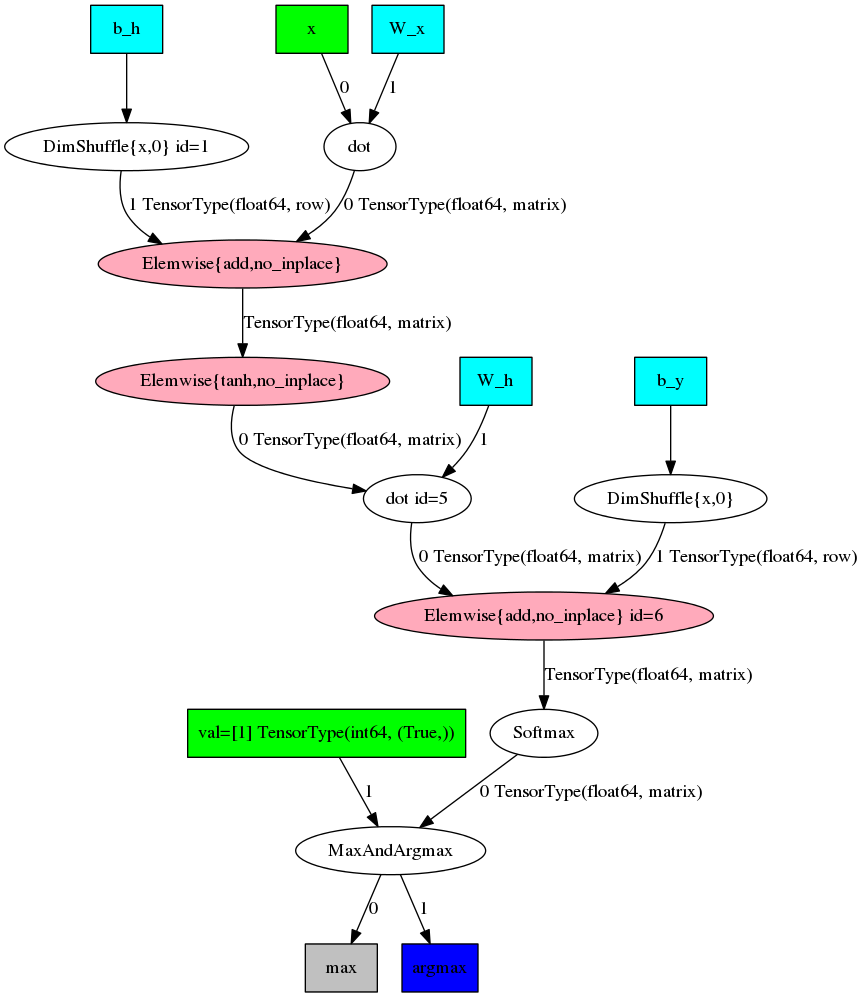

In [46]:
Image(filename='utilities/test.png') 

The second image shows the computational graph after the compilation

In [47]:
th.printing.pydotprint(f_test, outfile="utilities/test2.png", var_with_name_simple=True)

The output file is available at utilities/test2.png


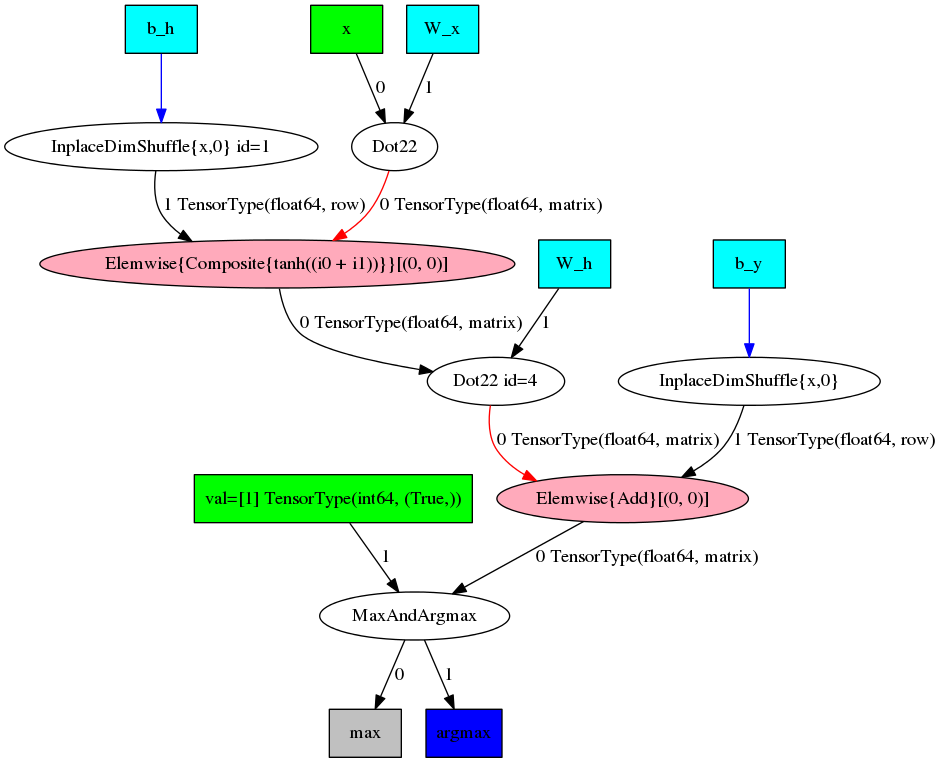

In [48]:
Image(filename='utilities/test2.png') 

---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.